In [19]:
from pathlib import Path
import re
import pandas as pd

# 노트북을 analysis/production 에서 실행 중이면 보통 이렇게 잡히는 게 깔끔합니다.
base_dir = Path.cwd() / "vot_measured"   # 예: .../analysis/production/vot_measured
# base_dir = Path(r"D:\\Github\\korean-stops\\analysis\\production\\vot_measured")  # 필요하면 고정 경로로

fname_re = re.compile(r"^resultsfile_(\d+)s\.txt$", re.IGNORECASE)

def _guess_encoding_from_bom(path: Path) -> str | None:
    head = path.read_bytes()[:4]
    if head.startswith(b"\xff\xfe") or head.startswith(b"\xfe\xff"):
        return "utf-16"
    if head.startswith(b"\xef\xbb\xbf"):
        return "utf-8-sig"
    return None

def read_results_tsv(path: Path) -> tuple[pd.DataFrame, str]:
    preferred = _guess_encoding_from_bom(path)
    encodings_to_try = [e for e in [preferred, "utf-8", "utf-8-sig", "cp949", "euc-kr"] if e]
    last_err: Exception | None = None
    for enc in encodings_to_try:
        try:
            df = pd.read_csv(
                path,
                sep="\t",                  # 파일이 탭 구분자
                na_values=["--undefined--"],
                encoding=enc,
            )
            return df, enc
        except UnicodeDecodeError as e:
            last_err = e
            continue

    # 최후의 수단: latin1(바이트-대-문자 1:1)로라도 읽어서 컬럼 구조 확인 가능하게
    # 필요하면 여기를 encoding_errors="replace" 로 바꿔도 됩니다.
    df = pd.read_csv(
        path,
        sep="\t",
        na_values=["--undefined--"],
        encoding="latin1",
    )
    if last_err is not None:
        print(f"[warn] {path.name}: failed encodings {encodings_to_try} -> latin1 fallback ({last_err})")
    return df, "latin1"

dfs_by_age = {}
for p in sorted(base_dir.glob("resultsfile_*s.txt")):
    m = fname_re.match(p.name)
    if not m:
        continue

    age = int(m.group(1))          # 20
    age_group = f"{age}s"          # "20s"

    df, used_enc = read_results_tsv(p)
    # print(f"Loaded {p.name} with encoding={used_enc}, rows={len(df)}")

    # 숫자 컬럼들은 확실히 float로 변환(undef 처리 포함)
    numeric_cols = [
        "duration",
        "f0_5ms_after_onset",
        "f0_5ms_plus_more_after_onset",
        "F1_midpoint",
        "F2_midpoint",
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df["age_group"] = age_group
    dfs_by_age[age_group] = df

# 전체 합친 DF도 필요하면
all_df = pd.concat(dfs_by_age.values(), ignore_index=True) if dfs_by_age else pd.DataFrame()

dfs_by_age.keys(), all_df.shape

(dict_keys(['20s']), (802, 8))

In [20]:
# Use "f0_5ms_plus_more_after_onset" instead of "f0_5ms_after_onset"
# duration means VOT
cleaned_df = all_df.drop(columns=["f0_5ms_after_onset", "F1_midpoint", "F2_midpoint"], errors="ignore").rename(columns={"f0_5ms_plus_more_after_onset": "f0", "duration": "vot"})
cleaned_df

,filename,label,vot,f0,age_group
0,201-1,kk,0.020234,264.205652,20s
1,201-1,i,0.209132,264.205652,20s
2,201-1,k,0.085736,215.710448,20s
3,201-1,i,0.278580,215.710448,20s
4,201-1,ph,0.090107,252.880797,20s
...,...,...,...,...,...
797,216-3,i,0.291684,83.569046,20s
798,216-3,kh,0.112722,110.512709,20s
799,216-3,a,0.104588,105.976855,20s
800,216-3,kh,0.149909,114.036659,20s


In [21]:
# 1. filename에서 prolific_participant_id와 session 추출
cleaned_df[['prolific_participant_id', 'session']] = cleaned_df['filename'].str.extract(r'^(\d+)-(\d+)')
cleaned_df['prolific_participant_id'] = pd.to_numeric(cleaned_df['prolific_participant_id'])
cleaned_df['session'] = pd.to_numeric(cleaned_df['session'])

# 2. workerids와 subject_information 로드
perception_data_dir = Path.cwd().parent / "perception" / "data"
workerids_df = pd.read_csv(perception_data_dir / "korean_stops_perception_3_poa_all_ages-workerids.csv")
workerids_df['prolific_participant_id'] = pd.to_numeric(workerids_df['prolific_participant_id'], errors='coerce')

subject_info_df = pd.read_csv(perception_data_dir / "korean_stops_perception_3_poa_all_ages-subject_information.csv")

# 3. prolific_participant_id -> workerid -> 정확한 나이 정보 매핑
cleaned_df = cleaned_df.merge(workerids_df, on='prolific_participant_id', how='left')
cleaned_df = cleaned_df.merge(subject_info_df[['workerid', 'age', 'gender']], on='workerid', how='left')

# 4. 데이터 확인
print(f"Total rows: {len(cleaned_df)}")
print(f"\nAge distribution:")
print(cleaned_df['age'].value_counts().sort_index())
print(f"\nGender distribution:")
print(cleaned_df['gender'].value_counts())
print(f"\nColumns: {list(cleaned_df.columns)}")
cleaned_df.head(10)

Total rows: 802

Age distribution:
age
20       50
22       54
24      108
25      321
26      107
28       54
34       54
3111     54
Name: count, dtype: int64

Gender distribution:
gender
Male      483
Female    319
Name: count, dtype: int64

Columns: ['filename', 'label', 'vot', 'f0', 'age_group', 'prolific_participant_id', 'session', 'workerid', 'age', 'gender']


,filename,label,vot,f0,age_group,prolific_participant_id,session,workerid,age,gender
0,201-1,kk,0.020234,264.205652,20s,201,1,393,28,Female
1,201-1,i,0.209132,264.205652,20s,201,1,393,28,Female
2,201-1,k,0.085736,215.710448,20s,201,1,393,28,Female
3,201-1,i,0.278580,215.710448,20s,201,1,393,28,Female
4,201-1,ph,0.090107,252.880797,20s,201,1,393,28,Female
5,201-1,i,0.185980,252.375605,20s,201,1,393,28,Female
6,201-1,p,0.068756,232.392260,20s,201,1,393,28,Female
7,201-1,i,0.213950,223.709780,20s,201,1,393,28,Female
8,201-1,tt,0.019287,293.154729,20s,201,1,393,28,Female
9,201-1,i,0.216789,293.603130,20s,201,1,393,28,Female


## 그래프 추천

현재 데이터:
- **VOT** (Voice Onset Time): 파열음의 조음 특성
- **F0** (fundamental frequency): 기본 주파수
- **나이**: 20-34세 (3111은 오류로 보임)
- **성별**: Male/Female
- **label**: 파열음 종류 (ㄱ/ㄲ/ㅋ, ㄷ/ㄸ/ㅌ, ㅂ/ㅃ/ㅍ 등)

### 추천 시각화:

1. **VOT vs F0 산점도** (파열음 타입별 색상)
   - 평음/경음/격음의 음향적 차이 확인
   
2. **나이별 VOT/F0 박스플롯**
   - 연령대별 조음 차이 탐색

3. **성별 비교**
   - 남녀 간 VOT/F0 차이

4. **히트맵/상관관계**
   - VOT, F0, 나이 간의 관계

5. **바이올린 플롯**
   - 파열음 타입별 분포 형태

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
sns.set_palette("husl")

# 이상치 제거 (3111세는 오류)
df_clean = cleaned_df[cleaned_df['age'] < 100].copy()

print(f"Cleaned data: {len(df_clean)} rows")
print(f"Age range: {df_clean['age'].min()}-{df_clean['age'].max()}")
print(f"\nLabels: {sorted(df_clean['label'].unique())}")

Cleaned data: 748 rows
Age range: 20-34

Labels: ['a', 'i', 'k', 'kh', 'kk', 'o', 'p', 'ph', 'pp', 't', 'th', 'tt']


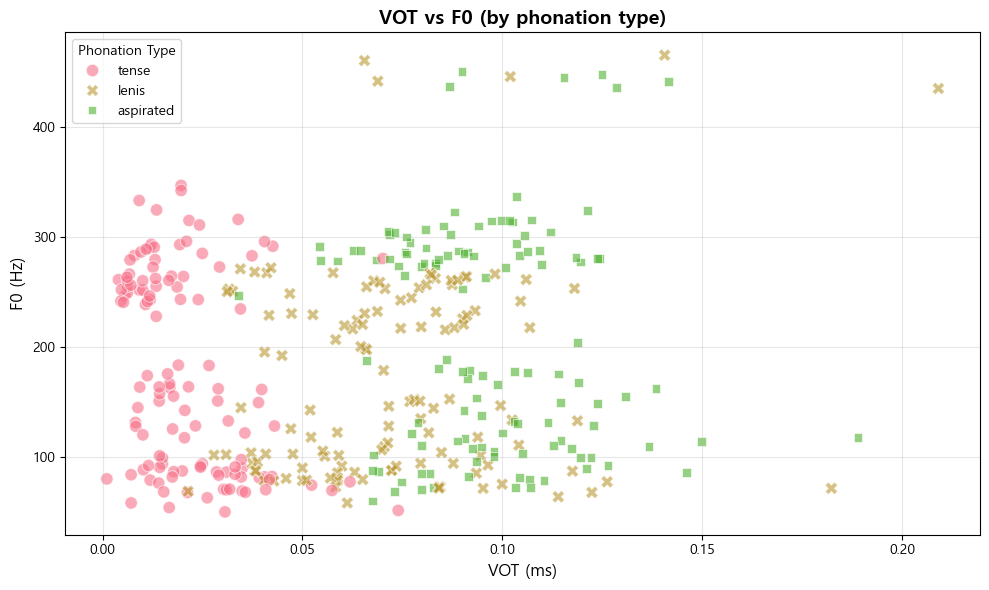


Stop consonant data: 375 rows
VOT range: 0.0 ~ 0.2 ms
F0 range: 50 ~ 465 Hz


In [25]:
# 1. VOT vs F0 scatter plot (by phonation type only)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Filter stops only (exclude vowels)
stops_df = df_clean[~df_clean['label'].isin(['a', 'i', 'o'])].copy()

# Classify by phonation type only
stops_df['phonation'] = stops_df['label'].map({
    'k': 'lenis', 'kk': 'tense', 'kh': 'aspirated',
    't': 'lenis', 'tt': 'tense', 'th': 'aspirated',
    'p': 'lenis', 'pp': 'tense', 'ph': 'aspirated',
})

# Scatter plot by phonation type
sns.scatterplot(data=stops_df, x='vot', y='f0', hue='phonation', 
                style='phonation', s=80, alpha=0.6, ax=ax)
ax.set_title('VOT vs F0 (by phonation type)', fontsize=14, fontweight='bold')
ax.set_xlabel('VOT (ms)', fontsize=12)
ax.set_ylabel('F0 (Hz)', fontsize=12)
ax.legend(title='Phonation Type', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStop consonant data: {len(stops_df)} rows")
print(f"VOT range: {stops_df['vot'].min():.1f} ~ {stops_df['vot'].max():.1f} ms")
print(f"F0 range: {stops_df['f0'].min():.0f} ~ {stops_df['f0'].max():.0f} Hz")

NaN values in f0_standardized: 0
f0_standardized range: -1.89 ~ 3.49


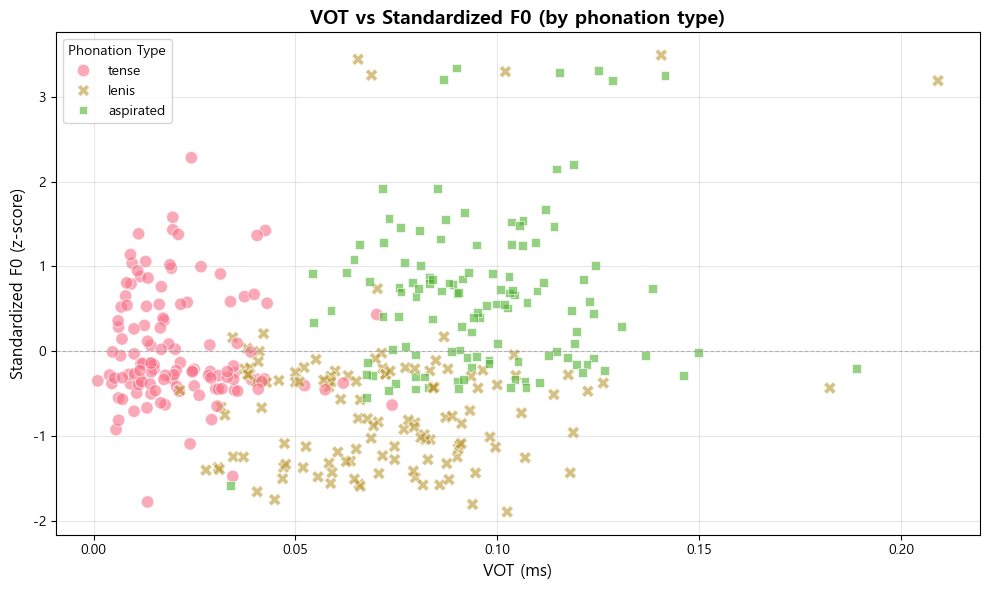


Standardized F0 by phonation type:
           count      mean       std       min       25%       50%       75%  \
phonation                                                                      
aspirated  123.0  0.622804  0.901633 -1.585909 -0.072852  0.558200  0.968735   
lenis      129.0 -0.610355  0.959297 -1.892503 -1.245988 -0.726630 -0.274974   
tense      123.0  0.017324  0.654276 -1.775774 -0.383523 -0.226774  0.477929   

                max  
phonation            
aspirated  3.339954  
lenis      3.490583  
tense      2.281610  


In [26]:
# Standardize F0 by participant
stops_df['f0_standardized'] = stops_df.groupby('prolific_participant_id')['f0'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)

# Check for any NaN values after standardization
print(f"NaN values in f0_standardized: {stops_df['f0_standardized'].isna().sum()}")
print(f"f0_standardized range: {stops_df['f0_standardized'].min():.2f} ~ {stops_df['f0_standardized'].max():.2f}")

# Plot VOT vs Standardized F0
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.scatterplot(data=stops_df, x='vot', y='f0_standardized', hue='phonation', 
                style='phonation', s=80, alpha=0.6, ax=ax)
ax.set_title('VOT vs Standardized F0 (by phonation type)', fontsize=14, fontweight='bold')
ax.set_xlabel('VOT (ms)', fontsize=12)
ax.set_ylabel('Standardized F0 (z-score)', fontsize=12)
ax.legend(title='Phonation Type', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

print(f"\nStandardized F0 by phonation type:")
print(stops_df.groupby('phonation')['f0_standardized'].describe())

Youngest participant: ID 215, Age 20
Number of observations: 25


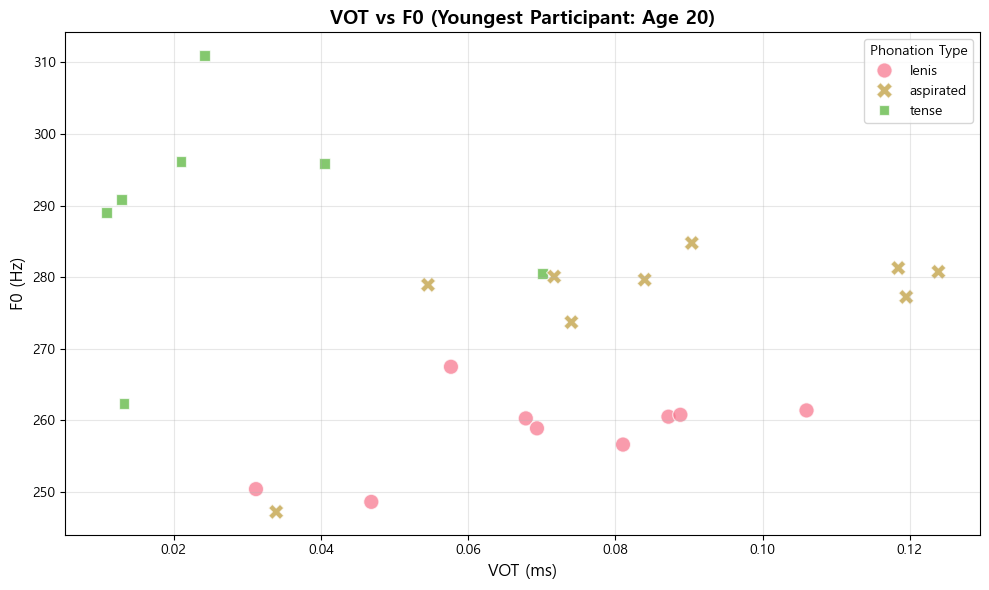


F0 by phonation type (youngest participant):
           count        mean        std         min         25%         50%  \
phonation                                                                     
aspirated    9.0  275.970075  11.186491  247.229964  277.248925  279.659650   
lenis        9.0  258.341646   5.790153  248.627261  256.630875  260.289379   
tense        7.0  289.409156  15.083532  262.393525  284.786155  290.854991   

                  75%         max  
phonation                          
aspirated  280.761098  284.786090  
lenis      260.791792  267.495246  
tense      296.012643  311.017982  


In [27]:
# Find the youngest participant
youngest_age = stops_df['age'].min()
youngest_participants = stops_df[stops_df['age'] == youngest_age]['prolific_participant_id'].unique()
youngest_participant = youngest_participants[0]

print(f"Youngest participant: ID {youngest_participant}, Age {youngest_age}")
print(f"Number of observations: {len(stops_df[stops_df['prolific_participant_id'] == youngest_participant])}")

# Filter data for the youngest participant
youngest_df = stops_df[stops_df['prolific_participant_id'] == youngest_participant].copy()

# Plot VOT vs F0 for youngest participant
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.scatterplot(data=youngest_df, x='vot', y='f0', hue='phonation', 
                style='phonation', s=120, alpha=0.7, ax=ax)
ax.set_title(f'VOT vs F0 (Youngest Participant: Age {youngest_age})', fontsize=14, fontweight='bold')
ax.set_xlabel('VOT (ms)', fontsize=12)
ax.set_ylabel('F0 (Hz)', fontsize=12)
ax.legend(title='Phonation Type', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nF0 by phonation type (youngest participant):")
print(youngest_df.groupby('phonation')['f0'].describe())

C:\Users\hanpe\AppData\Local\Temp\ipykernel_7924\3129447386.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stops_df, x='age', y='vot', palette='viridis', ax=axes[1, 0])
C:\Users\hanpe\AppData\Local\Temp\ipykernel_7924\3129447386.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stops_df, x='age', y='f0', palette='viridis', ax=axes[1, 1])


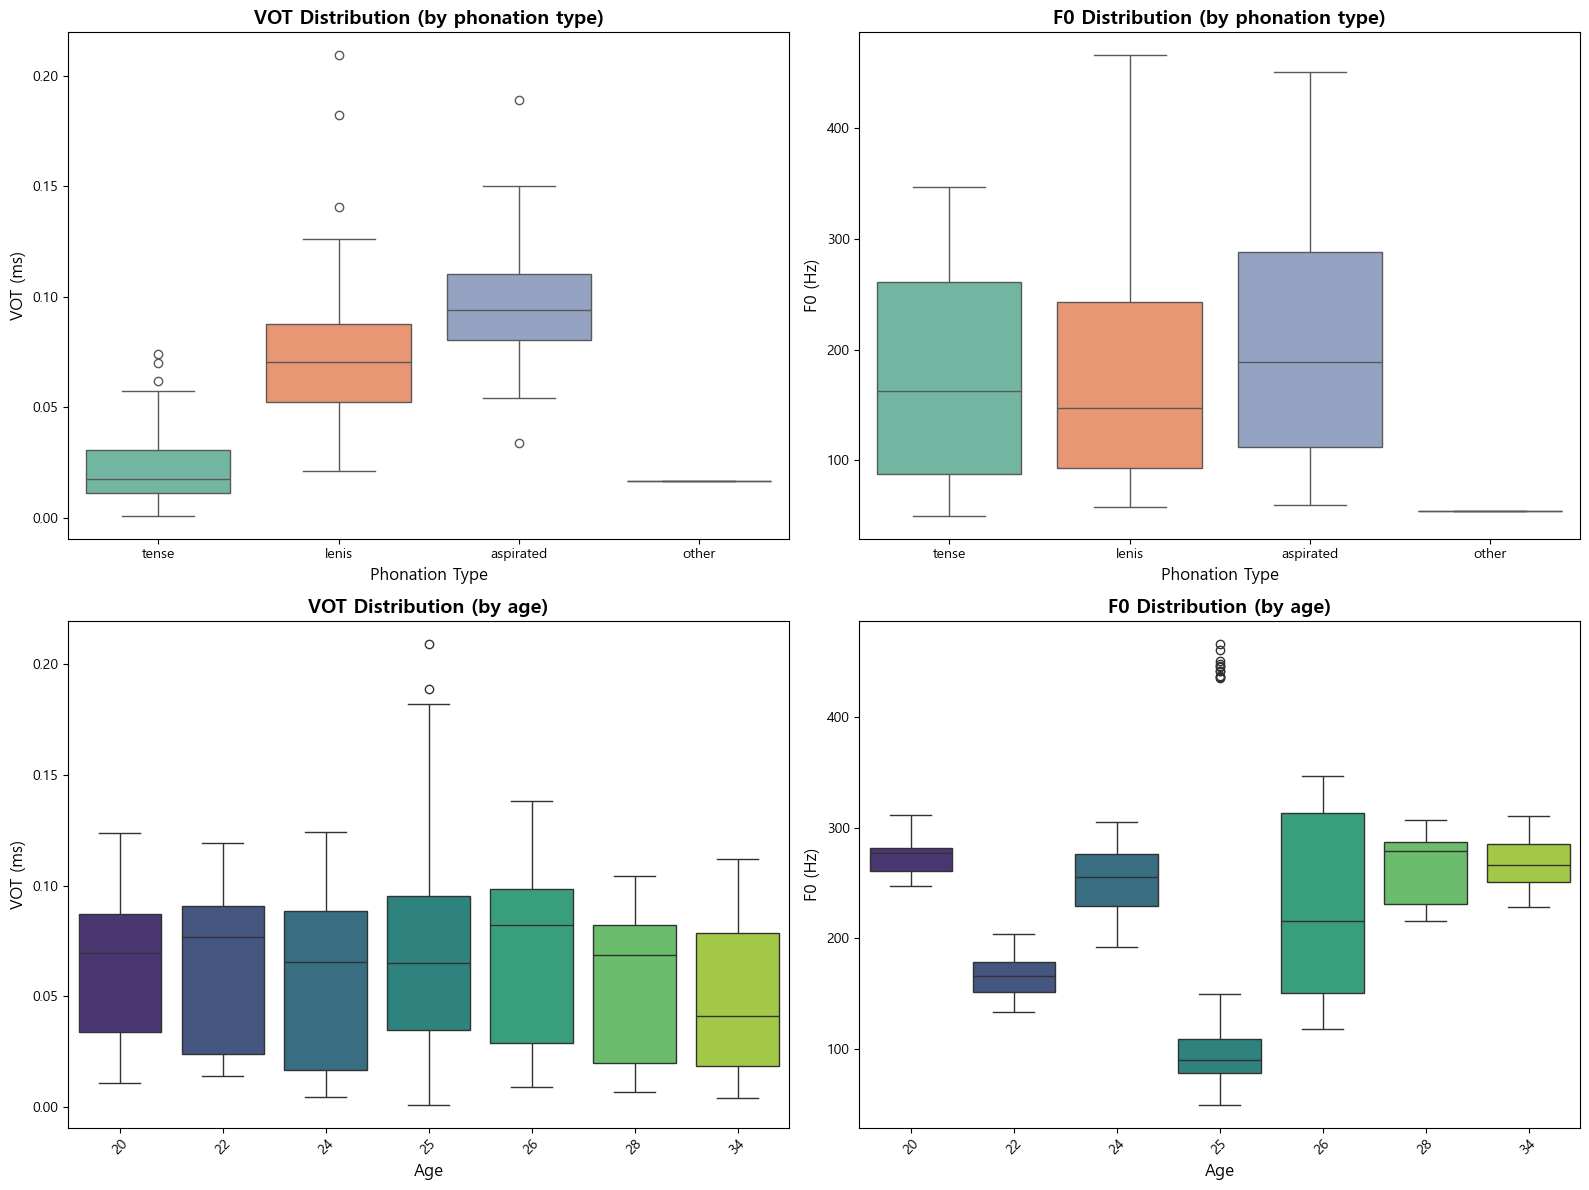

In [18]:
# 2. 나이별 VOT와 F0 분포 (박스플롯)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# VOT - 발성 유형별
sns.boxplot(data=stops_df, x='phonation', y='vot', hue='phonation', 
            palette='Set2', ax=axes[0, 0], legend=False)
axes[0, 0].set_title('VOT Distribution (by phonation type)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Phonation Type', fontsize=12)
axes[0, 0].set_ylabel('VOT (ms)', fontsize=12)

# F0 - 발성 유형별
sns.boxplot(data=stops_df, x='phonation', y='f0', hue='phonation', 
            palette='Set2', ax=axes[0, 1], legend=False)
axes[0, 1].set_title('F0 Distribution (by phonation type)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Phonation Type', fontsize=12)
axes[0, 1].set_ylabel('F0 (Hz)', fontsize=12)

# VOT - 나이별
sns.boxplot(data=stops_df, x='age', y='vot', palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('VOT Distribution (by age)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Age', fontsize=12)
axes[1, 0].set_ylabel('VOT (ms)', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)

# F0 - 나이별
sns.boxplot(data=stops_df, x='age', y='f0', palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('F0 Distribution (by age)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Age', fontsize=12)
axes[1, 1].set_ylabel('F0 (Hz)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()